# TensorFlow in action

## The data

These two lines of code will download and read in the data from the [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) automatically

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


![alt text](images/mnistdigits.gif "MNIST digits")

In [2]:
print(type(mnist))
print(type(mnist.train))

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>


The `mnist` variable contains a TensorFlow high level `Datasets` object, handling all the operations we'll perform on the data (labeling images, counting iterations during training, etc).

The MNIST data is split into three parts: 55,000 data points of training data (`mnist.train`), 10,000 points of test data (`mnist.test`), and 5,000 points of validation data (`mnist.validation`). This split is very important: it's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes.

Each MNIST data point has two parts: an image of a handwritten digit and a corresponding label. Both the training set and test set contain images and their corresponding labels; for example the training images are `mnist.train.images` and the training labels are `mnist.train.labels`. 

In [3]:
format_string = 'There are %d images and (of course) %d labels in the %s set'

print(format_string % (len(mnist.train.images), len(mnist.train.labels), 'training'))
print(format_string % (len(mnist.test.images), len(mnist.test.labels), 'test'))
print(format_string % (len(mnist.validation.images), len(mnist.validation.labels), 'validation'))

There are 55000 images and (of course) 55000 labels in the training set
There are 10000 images and (of course) 10000 labels in the test set
There are 5000 images and (of course) 5000 labels in the validation set


Each image is 28 pixels by 28 pixels. Grayscale images can be seen as arrays of numbers (pixels), with values ranging from 0 (black) to 1 (white).

In [4]:
import numpy as np

image = mnist.train.images[0]
print(image[200:300])

[ 0.          0.          0.          0.          0.          0.          0.
  0.38039219  0.37647063  0.3019608   0.46274513  0.2392157   0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.35294119  0.5411765   0.92156869  0.92156869  0.92156869  0.92156869
  0.92156869  0.92156869  0.98431379  0.98431379  0.97254908  0.99607849
  0.96078438  0.92156869  0.74509805  0.08235294  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.54901963  0.98431379  0.99607849  0.99607849  0.99607849
  0.99607849  0.99607849  0.99607849  0.99607849  0.99607849  0.99607849
  0.99607849  0.99607849  0.99607849  0.99607849  0.99607849  0.74117649
  0.09019608  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.88627458  0.99607849
  0.81568635  0.78039223  0.7803922

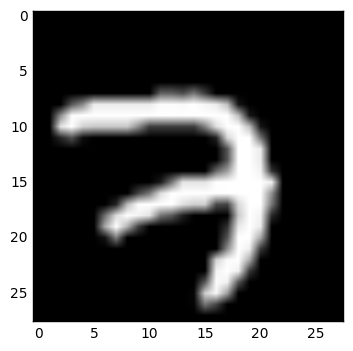

In [5]:
image = np.reshape(image, [28, 28])

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')

Let's check the image is actually labeled correctly. As we specified before, the labels are encoded as [one-hot](https://en.wikipedia.org/wiki/One-hot)

In [6]:
one_hot_label = mnist.train.labels[0]
label = np.where(one_hot_label==1.)[0]
print('The label is %s, which is the one-hot encoding for %d' % (one_hot_label, label))

The label is [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.], which is the one-hot encoding for 7


## The model

As a first simple model, we are going to implement a neural network performing softmax regression, which is a straightforward way to do classification. It looks like this:

![Softmax Regression](images/softmax-regression-scalargraph.png)

You can see how the input pixels (`x`) are _fully connected_ to the output layer neurons through weights and biases and the application of an activation function. Since we have 10 different classes (digits), the output layer will contain exactly 10 neurons. The activation function we are using to quantify the probabilities for an input to belong to a specific class is the softmax function.

![alt text](images/softmax.png "Softmax activation function")

Let's implement this simple model with TensorFlow!

In [7]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 28 * 28])

W = tf.Variable(tf.zeros([28 * 28, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

The majority of computation libraries out there help us compute expensive numerical operations by running them outside Python. TensorFlow does something a little bit different: it lets us describe a graph of interacting operations that run entirely outside Python. This approach is very common for a lot of machine learning libraries.

The code we have written in the cell above does not _compute_ anything. It just defines:
- a `placeholder`, i.e. a value that we'll input when we ask TensorFlow to run a computation
- the weights and biases `Variable`s
- the output `y` defined as the application of the softmax function over the matrix multiplication of the input and weights, plus the biases
All of these placeholders and variables are modeled with tensors. You have certainly seen tensors before: monodimensional tensors are vectors, while bidimensional tensors are matrices. Tensors are just a generalization to expand the concept to n dimensions.

The operations we define in TensorFlow typically take tensors as input and output some tensors. You see where we're going? The operation graph we define is just a flow of tensors, hence the name TensorFlow.

The only thing that can be a little tricky here is the dimensions of the tensors we have defined.

The placeholder has dimension `[None, 28 * 28]`. A dimension of `None` actually means that that dimension could be any valid number. We need a bidimensional tensor (matrix) to represent our input because we'll input a batch of images of 28 * 28 pixels during training. It doesn't matter how many images we'll _feed_ the model (how _big_ the batch we'll be) for the other operations to take place correctly.

The weights matrix will have as many rows as the number of input neurons and as many columns as the number of output neurons, hence the dimension `[28 * 28, 10]`. The biases vector will just have the dimension of the number of output neurons: `[10]`. We initialize weights and biases to zero for the sake of simplicity at the moment. You'll see how to initialize variables from distributions later on.

No dimension needs to be specified for the output `y` since it's of course a consequence of the operations on our variables, resulting in a dimension of `[None, 10]`.

## Training

Let's proceed patiently, one step at a time.

In [8]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

At some point in time, we'll need to calculate _how well_ the model is learning. We just need to define a loss function, for instance the cross-entropy function, and another placeholder, needed to input the labels with which to actually compute the loss.

*Warning*: you'll rarely see the cross-entropy function defined like that in a source code, because this formulation leads to numerical instability problems. TensorFlow deals with this issue by providing a `softmax_cross_entropy_with_logits` function, to be a applied to the unnormalized `tf.matmul(x, W) + b`. We use this more low-level cross-entropy definition to keep things explicit and clear.

We also define what a train step is for us, by appliying a gradient descent optimization with learning rate equal to 0.5 to minimize our cross-entropy. Again, `train_step` is yet another operation we define, it's not doing anything yet.

In [9]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

Now we have our model set up. Let's train it!

First, we create an operation to initialize the variables we created. Again, this `init` operation defines the operation but does not run it yet. We then finally launch the model in an `InteractiveSession`, and now we run the operation that initializes the variables before entering the training loop.

In the loop, we can just get the next train batch, and then run the `train_step` operation by feeding the model with the images and labels in our batch.

## Evaluation

We should now finally evaluate the performance of our model.

In [10]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.917


When can we say our prediction is correct? Well, simply when the label our model has generated by giving an image as input is the label assigned to that image. A little complication: since our labels are one-hot vectors and our predictions are probabilities, we need to extract the labels by retrieving the index of the max value in our vectors.

Once we know how to say when our model is correct, we can write an accuracy function as a simple average of all our correct predictions.

## Visualization

We can also visualize what our simple network is learning by plotting the weights of our network.

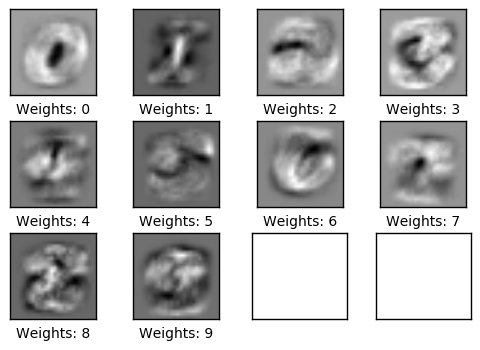

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_weights(session, weights, img_shape=(28, 28)):
    w = session.run(weights)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, axis in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i < 10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            axis.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            axis.imshow(image, cmap='gray')

        # Remove ticks from each sub-plot.
        axis.set_xticks([])
        axis.set_yticks([])
        
plot_weights(sess, W)

## Exercise 1

Ok, let's see if we can expand our humble network. Our new model is required to have an additional hidden layer, with its 300 neurons fully connected to the input and output neurons. The activation function we want to use in this case is the sigmoid (`tf.sigmoid(features)`). We also want to initialize our weights by sampling from a truncated normal distribution and biases as constants slightly greater than zero to avoid initialization problems. You can do that by initializing a `tf.Variable` with one of the following as first argument:

```tf.truncated_normal([input_neurons, output_neurons], stddev=1 / math.sqrt(input_neurons))
tf.constant(value, shape=[output_neurons])```

The best way to learn is by getting your hands dirty and trying to mess around with the code. You have 10 minutes to write your solution.